### Import dependencies

In [1]:
import cv2
import numpy as np
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import random
from sklearn.metrics import classification_report, confusion_matrix
import glob
import seaborn as sns
from torchvision import models
from torch.optim.lr_scheduler import ReduceLROnPlateau
from collections import Counter

# Data Augmentation

Data augmentation is a technique for generating new data samples from existing samples by applying random transformations. This helps the model become more robust and generalize better to unseen data. Explanation of the transformations:

- `RandomHorizontalFlip()`: Randomly flips some of the images horizontally.
- `RandomRotation(10)`: Randomly rotates some images within a range of ±10 degrees.
- `ColorJitter()`: Randomly adjusts the brightness, contrast, saturation, and hue of the images.
- `RandomAffine()`: Applies random affine transformations, including translation within a range of 10% of the image.

These transformations increase the diversity of the training data, helping to prevent overfitting and improving the model's ability to generalize.

In [2]:
class LungCancerDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((224, 224)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(10),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
            transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
        ])
        self.labels = {"adenocarcinoma": 0, "large.cell.carcinoma": 1, "normal": 2, "squamous.cell.carcinoma": 3}
        self.filepaths = []
        self.targets = []
        for label, idx in self.labels.items():
            paths = glob.glob(f"{root_dir}/{label}/*.png")
            self.filepaths.extend(paths)
            self.targets.extend([idx] * len(paths))

    def __len__(self):
        return len(self.filepaths)

    def __getitem__(self, index):
        filepath = self.filepaths[index]
        img = cv2.imread(filepath)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        if self.transform:
            img = self.transform(img)
        label = self.targets[index]
        return img, label
    
    def show_images(self, num_images=6, rows=2):
        """Display a grid of images randomly selected from the dataset."""
        cols = num_images // rows
        fig, axes = plt.subplots(rows, cols, figsize=(15, 5))
        indices = random.sample(range(len(self)), num_images)

        for ax, idx in zip(axes.flatten(), indices):
            img, label = self[idx]  # Get the image and label
            
            img = img.numpy().transpose((1, 2, 0))  # Convert to numpy array and correct the channel order
            mean = np.array([0.5, 0.5, 0.5])
            std = np.array([0.5, 0.5, 0.5])
            img = std * img + mean  # Unnormalize
            img = np.clip(img, 0, 1)  # Clip the image pixel values
            
            ax.imshow(img)
            ax.axis('on')  # Turn off axis
            label_name = list(self.labels.keys())[list(self.labels.values()).index(label)]  # Get label name
            ax.set_title(label_name)
        
        # Reduce padding
        plt.subplots_adjust(wspace=0.1, hspace=0.2)  # Adjust the spacing between images
        plt.show()

In [3]:
train_dataset = LungCancerDataset(root_dir='./data/train')
valid_dataset = LungCancerDataset(root_dir='./data/valid')

train_count = Counter(train_dataset.targets)
valid_count = Counter(valid_dataset.targets)

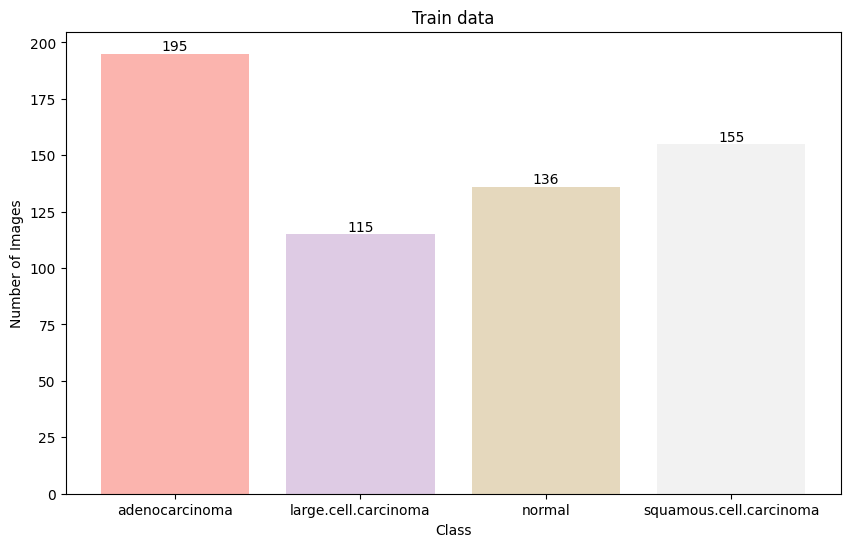

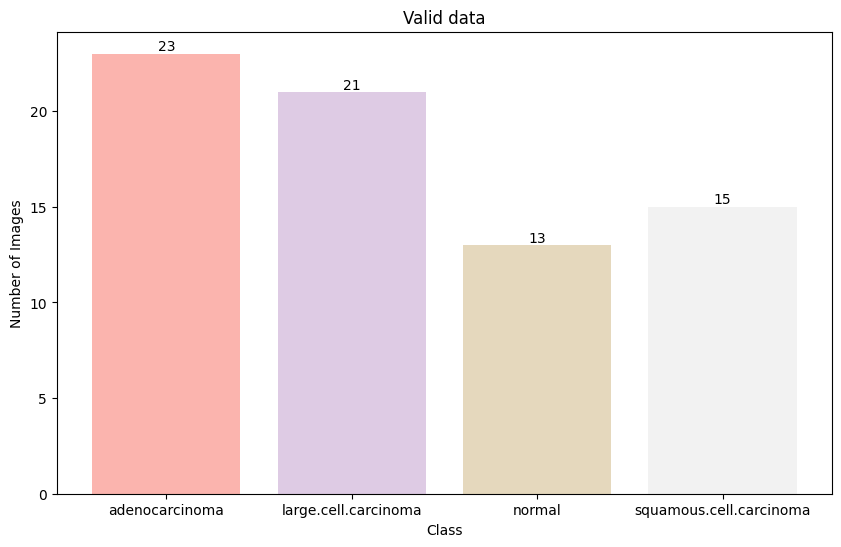

In [4]:
def plot_nimages(dataset, count, name):
    class_names = list(dataset.labels.keys())
    counts = [count[dataset.labels[class_name]] for class_name in class_names]

    colors = plt.cm.Pastel1(np.linspace(0, 1, len(class_names)))

    plt.figure(figsize=(10, 6))
    for i, class_name in enumerate(class_names):
        plt.bar(class_name, counts[i], color=colors[i])

    plt.title(name)
    plt.xlabel('Class')
    plt.ylabel('Number of Images')

    for index, value in enumerate(counts):
        plt.text(index, value, str(value), ha='center', va='bottom')

    plt.show()
    
plot_nimages(train_dataset, train_count, name='Train data')
plot_nimages(valid_dataset, valid_count, name='Valid data')

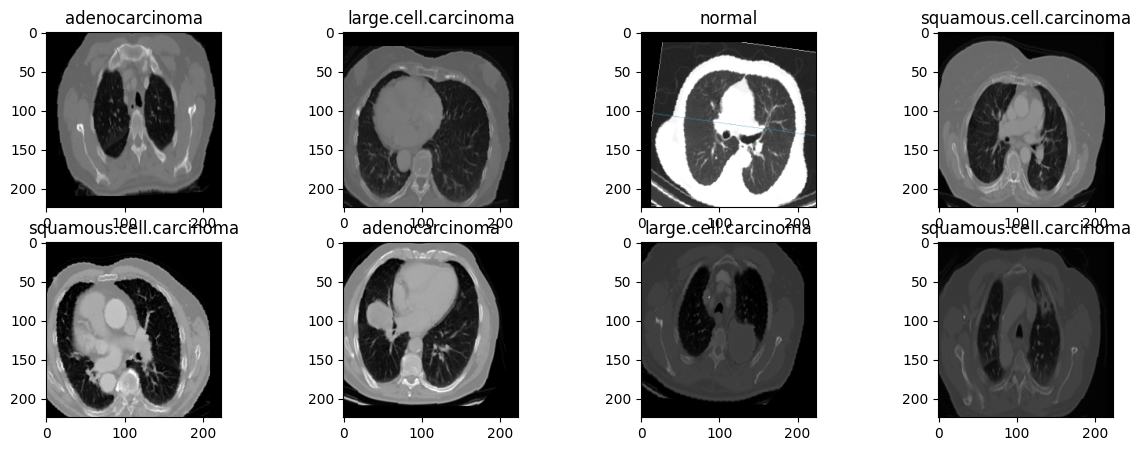

In [5]:
train_dataset.show_images(num_images=8, rows=2)

## ModifiedResNet50 Architecture Explanation

The ModifiedResNet50 is an adaptation of the standard ResNet50 architecture, tailored for a specific classification task with four classes. The ResNet50 model is a deep convolutional neural network that is 50 layers deep, designed to address the vanishing gradient problem by incorporating residual connections. Here's a detailed explanation of the modifications and the overall architecture:

### Base Model: ResNet50

- **Pretrained Weights**: The model uses pretrained weights on ImageNet, which helps in leveraging transfer learning. This means the model has already learned to extract useful features from a large and diverse dataset.

### Custom Modifications

1. **Output Layer Adjustment**:
    - The original ResNet50 model's fully connected (fc) layer is designed for 1000 classes. In this modified version, the final fully connected layer is replaced to output four classes.
    - **`nn.Linear` Layer**: This layer is changed to have the appropriate output size for the task (`num_classes=4`).
    - **`nn.Dropout` Layer**: A dropout layer with a rate of 0.5 is added before the final fully connected layer to help prevent overfitting. Dropout randomly sets a fraction of the input units to 0 at each update during training time, which helps in regularizing the model.

2. **Batch Normalization**:
    - A batch normalization layer (`nn.BatchNorm1d`) is added before the final classification layer. Batch normalization normalizes the output of the previous layer, which helps in speeding up the training process and providing some regularization.

### Architecture Details

1. **Initial Layers**:
    - `conv1`: The first convolutional layer which applies a set of filters to the input image.
    - `bn1`: Batch normalization layer to normalize the output of `conv1`.
    - `relu`: ReLU activation function to introduce non-linearity.
    - `maxpool`: Max pooling layer to reduce the spatial dimensions of the feature maps.

2. **Residual Layers**:
    - `layer1`, `layer2`, `layer3`, `layer4`: These are the residual blocks of the ResNet50 model. Each block consists of multiple convolutional layers with skip connections (residual connections) that help in preventing the vanishing gradient problem and allow the model to learn deeper representations.

3. **Pooling Layer**:
    - `avgpool`: Global average pooling layer that reduces the spatial dimensions to 1x1, creating a feature vector that summarizes the information from the feature maps.

4. **Flattening**:
    - The output of the average pooling layer is flattened to a 1-dimensional tensor, which is suitable for input to the fully connected layer.

5. **Batch Normalization**:
    - The flattened feature vector is passed through a batch normalization layer to stabilize and normalize the inputs to the final fully connected layer.

6. **Fully Connected Layer with Dropout**:
    - The batch-normalized features are then passed through the dropout layer and the final fully connected layer to produce the class scores.

### Forward Pass

During the forward pass, the input image `x` goes through the following steps:

1. Convolution and pooling layers: `conv1 -> bn1 -> relu -> maxpool`
2. Residual layers: `layer1 -> layer2 -> layer3 -> layer4`
3. Average pooling: `avgpool`
4. Flattening: `torch.flatten(x, 1)`
5. Batch normalization: `batch_norm`
6. Fully connected layer with dropout: `model.fc`

### Summary

The ModifiedResNet50 leverages the robust feature extraction capabilities of the pretrained ResNet50 model while tailoring the final layers to the specific task of four-class classification. The inclusion of dropout and batch normalization helps in regularizing the model, improving its generalization capabilities, and accelerating the training process.

In [6]:
class ModifiedResNet50(nn.Module):
    def __init__(self, num_classes=4):
        super(ModifiedResNet50, self).__init__()
        self.model = models.resnet50(pretrained=True)
        num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(num_ftrs, num_classes)
        )
        self.batch_norm = nn.BatchNorm1d(num_ftrs)

    def forward(self, x):
        x = self.model.conv1(x)
        x = self.model.bn1(x)
        x = self.model.relu(x)
        x = self.model.maxpool(x)
        x = self.model.layer1(x)
        x = self.model.layer2(x)
        x = self.model.layer3(x)
        x = self.model.layer4(x)
        x = self.model.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.batch_norm(x)
        x = self.model.fc(x)
        return x

# Regularization

Regularization is a technique used to prevent overfitting, which occurs when a model fits the training data too well and fails to generalize to new data. Explanation of the Dropout layer:

- `Dropout(0.5)`: During training, this layer randomly deactivates 50% of the neurons in the fully connected layer for each forward pass. This forces the network not to rely too much on certain neurons, helping to prevent overfitting.

# Hyperparameter Tuning

Tuning the model's hyperparameters, such as the learning rate and optimizer, can significantly impact the model's performance. Changes made:

Using the Adam optimizer with weight decay (L2 regularization). Explanation of the Adam optimizer:

- `Adam`: An adaptive optimizer that adjusts the learning rates for each parameter. It is known for its effectiveness and efficiency in practice.
- `weight_decay=1e-5`: This is an L2 regularization technique that penalizes large weights in the model, helping to prevent overfitting.

Implementation of a learning rate scheduler. Explanation of the learning rate scheduler:

- `ReduceLROnPlateau`: This scheduler reduces the learning rate when a metric (in this case, loss) has stopped improving. Specifically, it reduces the learning rate by a factor of 0.1 if there is no improvement in loss after 5 epochs.

# Updated Training and Validation Functions

Training function. Explanation of the training function:

- `model.train()`: Puts the model in training mode.
- `optimizer.zero_grad()`: Resets the optimizer's gradients before the backward pass.
- `loss.backward()`: Computes the loss gradient with respect to the model's parameters.
- `optimizer.step()`: Updates the model's parameters based on the computed gradients.
- `scheduler.step(epoch_loss)`: Adjusts the learning rate based on the epoch loss.


In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ModifiedResNet50().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

def train_model(dataloader, model, criterion, optimizer, num_epochs):
    train_loss_history = []
    valid_loss_history = []
    valid_acc_history = []
    
    best_model_wts = None
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        running_loss = 0.0
        model.train()
        
        for i, (inputs, labels) in enumerate(dataloader['train']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
        
        epoch_loss = running_loss / len(dataloader['train'].dataset)
        train_loss_history.append(epoch_loss)
        
        val_loss, val_acc = validate_model(dataloader['valid'], model, device, criterion)
        valid_loss_history.append(val_loss)
        valid_acc_history.append(val_acc)
        
        print(f'Epoch {epoch}/{num_epochs - 1}, Train Loss: {epoch_loss}, Validation Loss: {val_loss}, Validation Accuracy: {val_acc}')
        scheduler.step(val_loss)
        
        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = model.state_dict().copy()
    
    print(f'Best Validation Accuracy: {best_acc}')
    model.load_state_dict(best_model_wts)
    torch.save(model.state_dict(), 'best_model.pth')
    
    return train_loss_history, valid_loss_history, valid_acc_history

/home/drtey/chest-CT-Scan/ctscan/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/drtey/chest-CT-Scan/ctscan/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/drtey/chest-CT-Scan/ctscan/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Validation function. Explanation of the validation function:

- `model.eval()`: Puts the model in evaluation mode (disables dropout layers and other training-specific features).
- `torch.no_grad()`: Disables gradient calculation, reducing memory usage and speeding up evaluation.
- `torch.max(outputs, 1)`: Obtains the model's predictions.

In [8]:
def validate_model(dataloader, model, device, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    
    loss = running_loss / len(dataloader.dataset)
    accuracy = correct / total
    
    return loss, accuracy

# Model Evaluation

Explanation of the test function:

- Similar to the validation function but calculates accuracy on the test dataset.

Calculation and visualization of the confusion matrix.

Epoch 0/99, Train Loss: 1.0785974841347947, Validation Loss: 1.1686755816141765, Validation Accuracy: 0.4583333333333333
Epoch 1/99, Train Loss: 0.598971124000835, Validation Loss: 1.0995440483093262, Validation Accuracy: 0.4722222222222222
Epoch 2/99, Train Loss: 0.3299107628435938, Validation Loss: 0.6798301140467325, Validation Accuracy: 0.7638888888888888
Epoch 3/99, Train Loss: 0.19857356005569862, Validation Loss: 0.521555761496226, Validation Accuracy: 0.8472222222222222
Epoch 4/99, Train Loss: 0.12081204372118792, Validation Loss: 0.5606298844019572, Validation Accuracy: 0.8333333333333334
Epoch 5/99, Train Loss: 0.09071618510710816, Validation Loss: 0.6045213792886999, Validation Accuracy: 0.8055555555555556
Epoch 6/99, Train Loss: 0.0632495453671092, Validation Loss: 0.3994729202758107, Validation Accuracy: 0.9027777777777778
Epoch 7/99, Train Loss: 0.07520457504692173, Validation Loss: 0.4917478594515059, Validation Accuracy: 0.875
Epoch 8/99, Train Loss: 0.04012219340055437

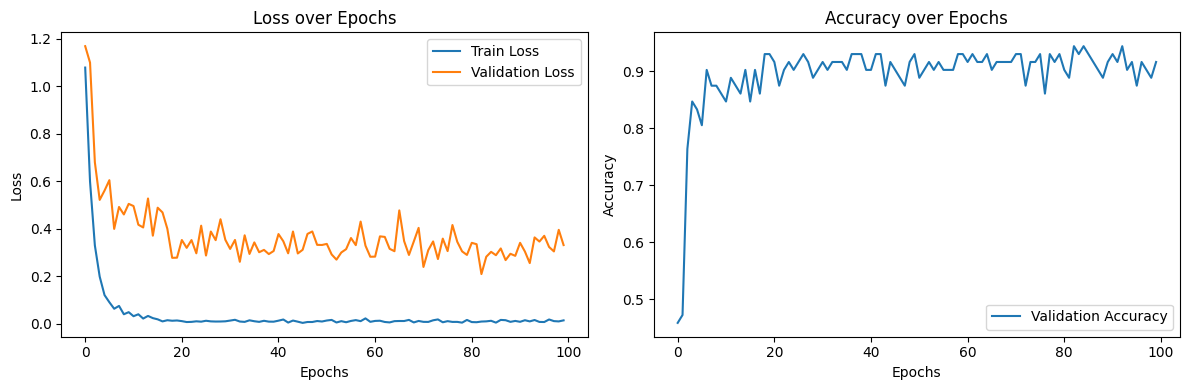

Accuracy of the model on the test images: 94.28571428571428%


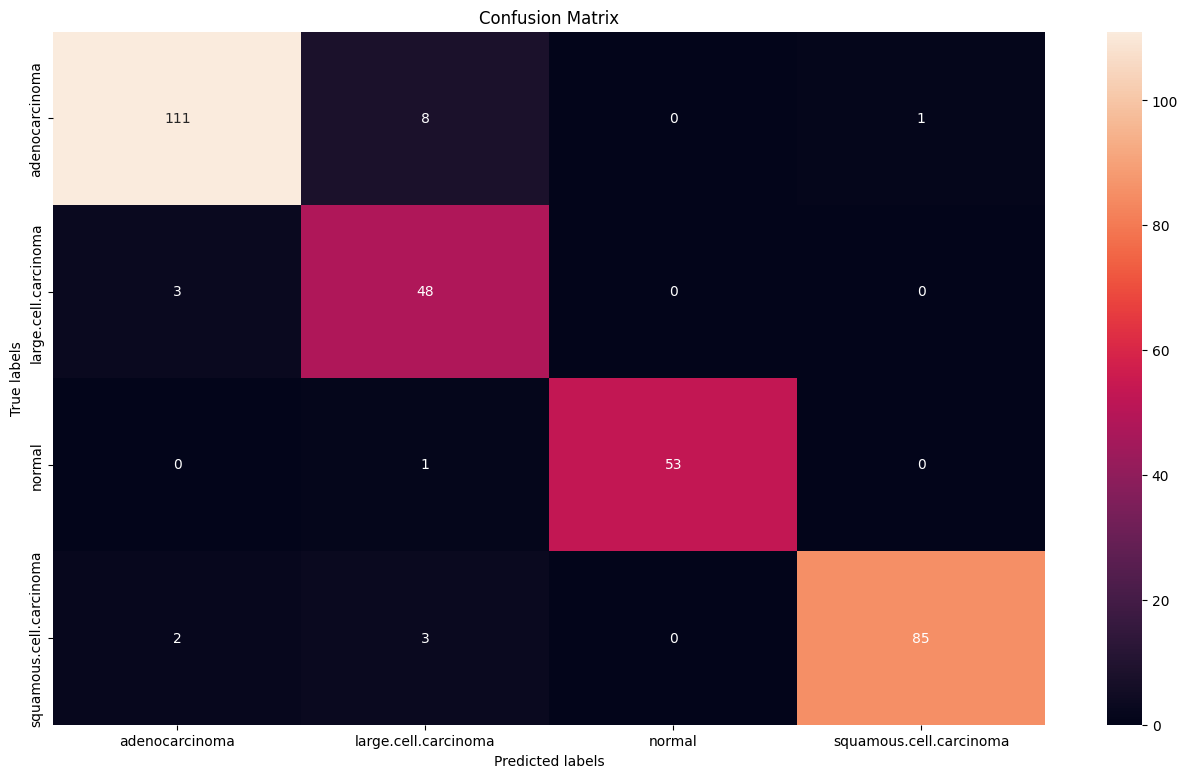

                         precision    recall  f1-score   support

         adenocarcinoma       0.96      0.93      0.94       120
   large.cell.carcinoma       0.80      0.94      0.86        51
                 normal       1.00      0.98      0.99        54
squamous.cell.carcinoma       0.99      0.94      0.97        90

               accuracy                           0.94       315
              macro avg       0.94      0.95      0.94       315
           weighted avg       0.95      0.94      0.94       315



In [9]:
def plot_metrics(train_loss, valid_loss, valid_acc):
    epochs = range(len(train_loss))
    
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, label='Train Loss')
    plt.plot(epochs, valid_loss, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss over Epochs')
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs, valid_acc, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy over Epochs')
    
    plt.tight_layout()
    plt.show()

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=64, shuffle=False)

dataloader = {'train': train_dataloader, 'valid': valid_dataloader}

num_epochs = 100
train_loss, valid_loss, valid_acc = train_model(dataloader, model, criterion, optimizer, num_epochs)

plot_metrics(train_loss, valid_loss, valid_acc)

test_dataset = LungCancerDataset(root_dir='./data/test')
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

def test_model(test_dataloader, model, device):
    model.eval()
    correct = 0
    total = 0
    all_predictions = []
    all_labels = []
    with torch.no_grad():
        for images, labels in test_dataloader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    accuracy = correct / total
    print(f'Accuracy of the model on the test images: {100 * accuracy}%')
    return all_labels, all_predictions

test_labels, test_predictions = test_model(test_dataloader, model, device)

cm = confusion_matrix(test_labels, test_predictions)
plt.figure(figsize=(16, 9))
ax = plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['adenocarcinoma', 'large.cell.carcinoma', 'normal', 'squamous.cell.carcinoma'])
ax.yaxis.set_ticklabels(['adenocarcinoma', 'large.cell.carcinoma', 'normal', 'squamous.cell.carcinoma'])
plt.show()

print(classification_report(test_labels, test_predictions, target_names=['adenocarcinoma', 'large.cell.carcinoma', 'normal', 'squamous.cell.carcinoma']))